# Income Prediction and Analysis

## Problem Statement

Develop a comprehensive analysis and predictive model to understand and forecast individual income based on various correlated factors.

The adult dataset is from 1996 ([details](https://www.cs.toronto.edu/~delve/data/adult/adultDetail.html)).

## Imports and utility functions

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency, pearsonr
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

In [48]:
def stacked_bar_income(group_key, ax=None):
    income_counts = df.groupby([group_key, 'income']).size().unstack(fill_value=0)
    income_percentages = income_counts.div(income_counts.sum(axis=1), axis=0) * 100
    income_percentages = income_percentages.reset_index().sort_values('>50K', ascending=False)
    if ax is None:
        fig, ax = plt.subplots()
    
    income_percentages.plot(kind='bar', x=group_key, stacked=True, ax=ax)
    
    ax.set_title(f"Percentage plot of income distribution by {group_key}")
    ax.set_ylabel('%')
    ax.set_xlabel(group_key)

## Data Wrangling

In this section, we perform the following actions:

- __Import Data__: Load the dataset into our working environment.
- __Replace N/A Values__: Replace missing values with "Unknown" for categorical variables to handle incomplete data.
- __Drop Duplicates__: Remove duplicate entries to ensure data integrity.
- __Resample Data__: Resample the dataset using fnlwgt (final weight) as a weight, allowing us to perform analysis that represents the sampled population distribution.
- __Feature engineering__: Add a binary income column so that we can perform numerical analysis if needed.


In [49]:
# Import data
df = pd.read_csv("adult.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [50]:
df = df.replace('?', np.NaN)

In [51]:
df.isna().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [52]:
df = df.fillna('Unknown')
df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [53]:
# Since most of the value in capital-gain and capital-loss is 0, drop the columns
df.drop(columns=["capital-gain", "capital-loss"], inplace=True)

In [54]:
# Each row represents a unique set of population. Make sure the row is unique
df = df.drop_duplicates()

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48782 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48782 non-null  int64 
 1   workclass        48782 non-null  object
 2   fnlwgt           48782 non-null  int64 
 3   education        48782 non-null  object
 4   educational-num  48782 non-null  int64 
 5   marital-status   48782 non-null  object
 6   occupation       48782 non-null  object
 7   relationship     48782 non-null  object
 8   race             48782 non-null  object
 9   gender           48782 non-null  object
 10  hours-per-week   48782 non-null  int64 
 11  native-country   48782 non-null  object
 12  income           48782 non-null  object
dtypes: int64(4), object(9)
memory usage: 5.2+ MB


In [56]:
# Resample data based on fnlwgt. Resample df*10 to make sure the resampled data can represent the distribution well.
df = df.sample(n=len(df)*10, replace=True, weights='fnlwgt').drop(columns=['fnlwgt'])
df.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income
41952,24,Private,Some-college,10,Never-married,Machine-op-inspct,Own-child,Other,Male,14,United-States,<=50K
12610,38,Private,11th,7,Widowed,Craft-repair,Unmarried,White,Male,40,United-States,<=50K
5330,23,Private,Assoc-voc,11,Never-married,Adm-clerical,Not-in-family,White,Male,50,United-States,<=50K
17705,53,Federal-gov,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,Black,Male,40,United-States,<=50K
7163,28,Private,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,40,United-States,<=50K


In [57]:
df['income_binary'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)
df.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income,income_binary
41952,24,Private,Some-college,10,Never-married,Machine-op-inspct,Own-child,Other,Male,14,United-States,<=50K,0
12610,38,Private,11th,7,Widowed,Craft-repair,Unmarried,White,Male,40,United-States,<=50K,0
5330,23,Private,Assoc-voc,11,Never-married,Adm-clerical,Not-in-family,White,Male,50,United-States,<=50K,0
17705,53,Federal-gov,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,Black,Male,40,United-States,<=50K,0
7163,28,Private,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,40,United-States,<=50K,0


## EDA

In this section, we perform the following actions:
- Summary Statistics: Generate summary statistics to gain insights into the central tendencies and dispersions of numerical variables.
- Income Distribution Analysis: Examine how various features affect the distribution of income.
- Categorical Variable Analysis: Understand the distribution and frequency of categorical variables to identify dominant categories and potential data imbalances.
- Correlation Analysis: Identify significant relationships between numerical variables to understand their interconnections.


In [58]:
df_low_income = df[df['income'] == "<=50K"]
df_high_income = df[df['income'] == ">50K"]

### Summary statistics

In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,487820.0,38.076387,13.530781,17.0,27.0,36.0,47.0,90.0
educational-num,487820.0,10.031387,2.612008,1.0,9.0,10.0,12.0,16.0
hours-per-week,487820.0,40.311467,12.150349,1.0,40.0,40.0,45.0,99.0
income_binary,487820.0,0.239418,0.426729,0.0,0.0,0.0,0.0,1.0


### Income distribution

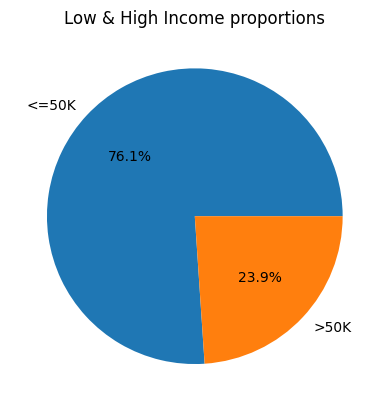

In [60]:
plt.pie([len(df_low_income), len(df_high_income)], labels=['<=50K', '>50K'], autopct='%1.1f%%')
plt.title('Low & High Income proportions')
plt.show()

### Categorical Variable Distribution

In [61]:
cat_columns = df.select_dtypes(include=['object']).drop(columns=['income'])
cat_columns.columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object')

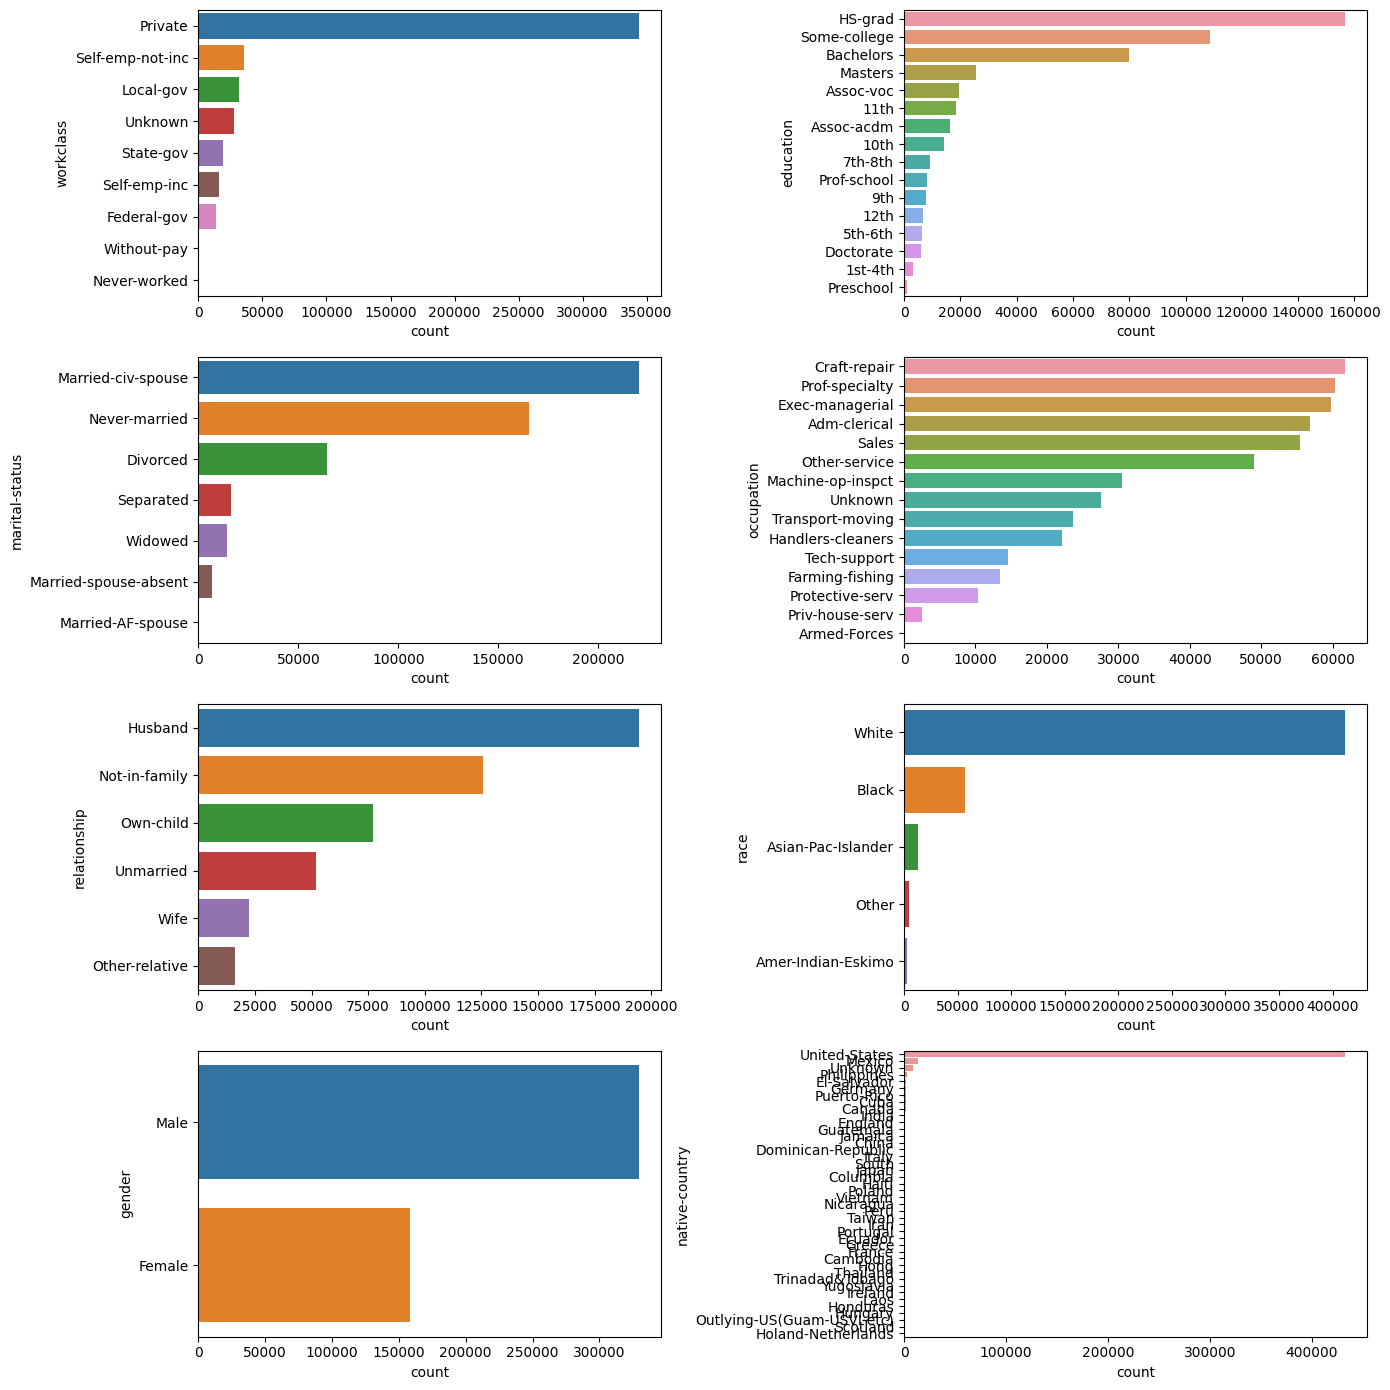

In [62]:
fig, axes = plt.subplots(4,2, figsize=(14,14))

for idx, col in enumerate(cat_columns.columns):
    row_idx = idx // 2
    col_idx = idx % 2
    sns.countplot(data=df, y=col,  ax=axes[row_idx, col_idx], order = df[col].value_counts().index)


plt.tight_layout()
plt.show()

### Income distribution by age

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a len

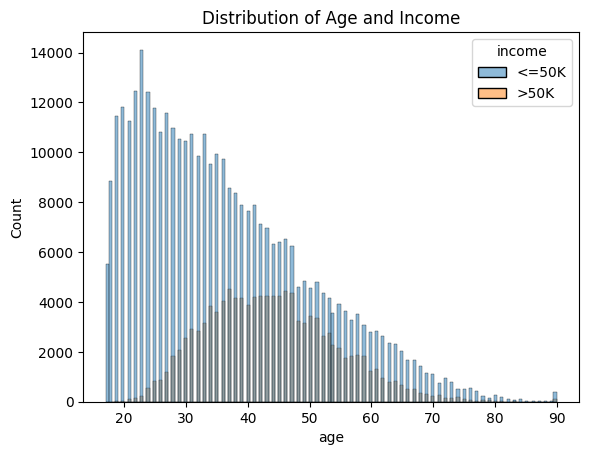

In [63]:
sns.histplot(data=df, x='age', hue='income')
plt.title('Distribution of Age and Income')
plt.show()

In [64]:
stats.normaltest(df_high_income.age), stats.normaltest(df_low_income.age)
# The age grouped by income is not normally distributed. 

(NormaltestResult(statistic=4380.761688092105, pvalue=0.0),
 NormaltestResult(statistic=31138.79923812063, pvalue=0.0))

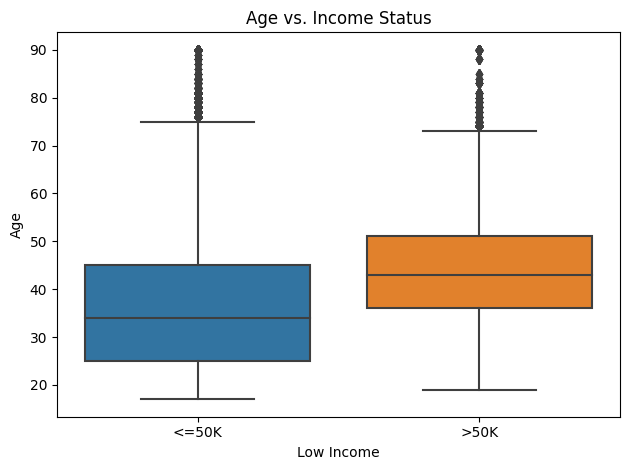

In [65]:
# Add boxplot
sns.boxplot(x='income', y='age', data=df)
plt.title('Age vs. Income Status')
plt.xlabel('Low Income')
plt.ylabel('Age')

# Displaying the plot
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Age distribution for <=50k vs >50k')

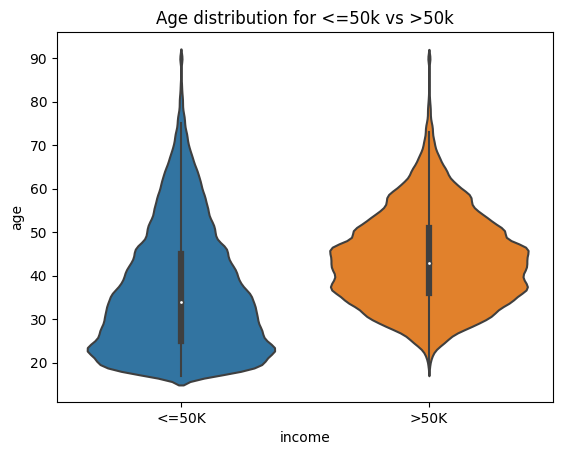

In [66]:
sns.violinplot(data=df, x='income', y='age')
plt.title('Age distribution for <=50k vs >50k')

In [67]:
t_stat, p_val = ttest_ind(df_low_income.age, df_high_income.age, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

T-statistic: -198.95034709491358, P-value: 0.0


There is a statistical significance of showing the age has affect on income.

### Income distribution by Workclass & Occupation 

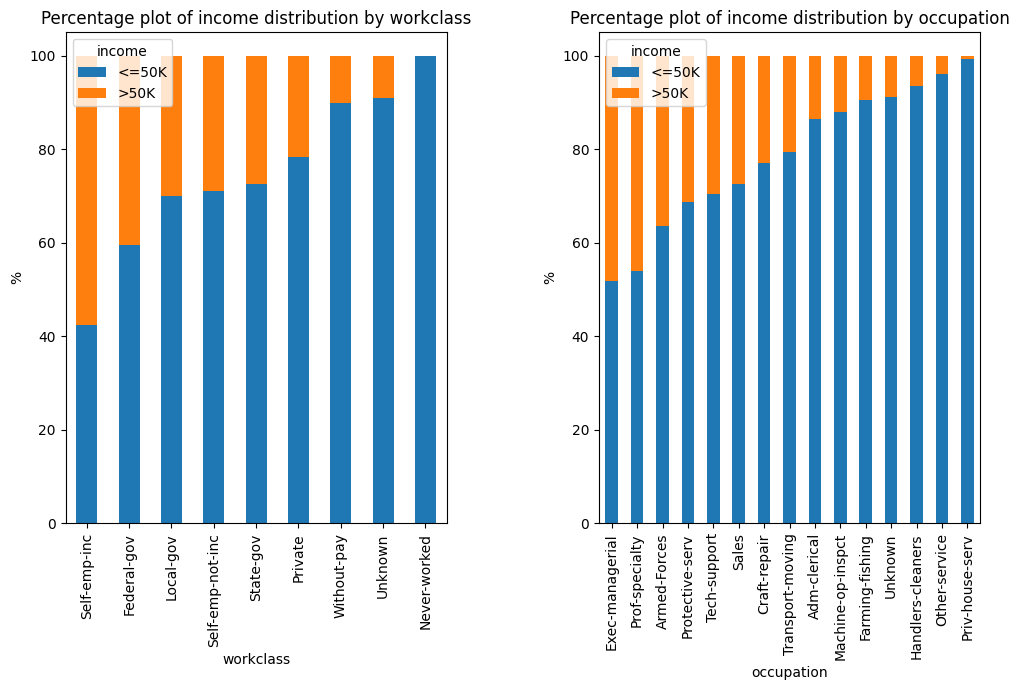

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
stacked_bar_income('workclass', ax=axes[0])
stacked_bar_income('occupation', ax=axes[1])

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)  
plt.show()

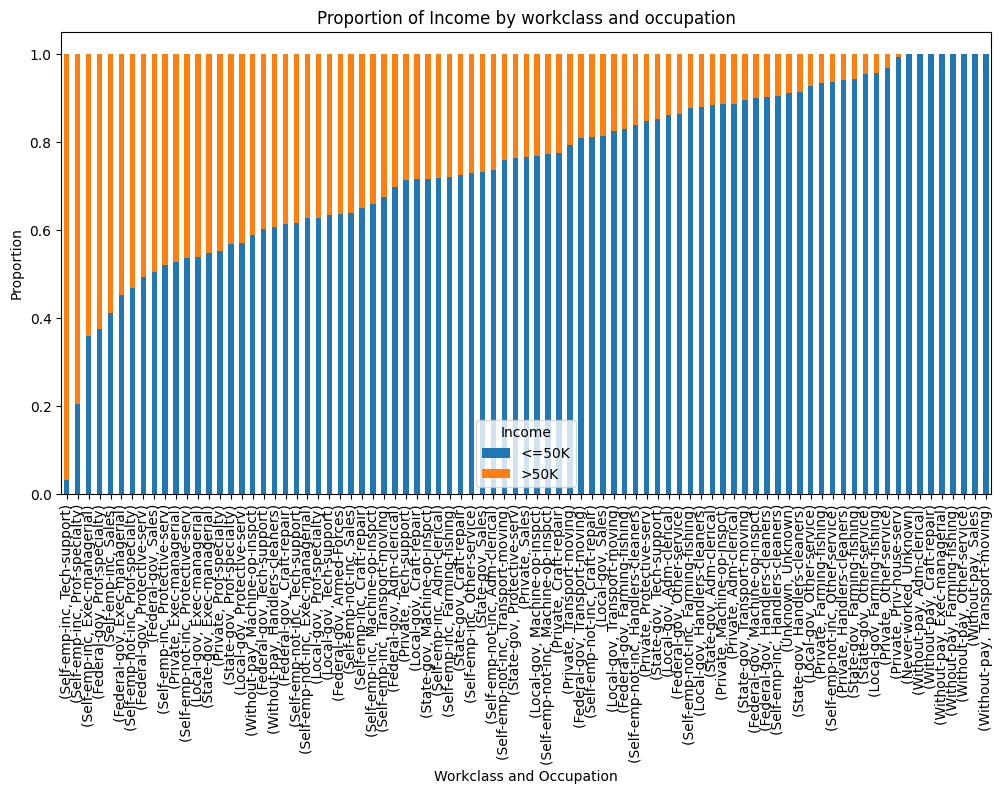

In [69]:
proportions = df.groupby(['workclass', 'occupation'])['income'].value_counts(normalize=True).unstack().sort_values(by='>50K', ascending=False)
proportions.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Proportion of Income by workclass and occupation')
plt.xlabel('Workclass and Occupation')
plt.ylabel('Proportion')
plt.legend(title='Income')
plt.show()

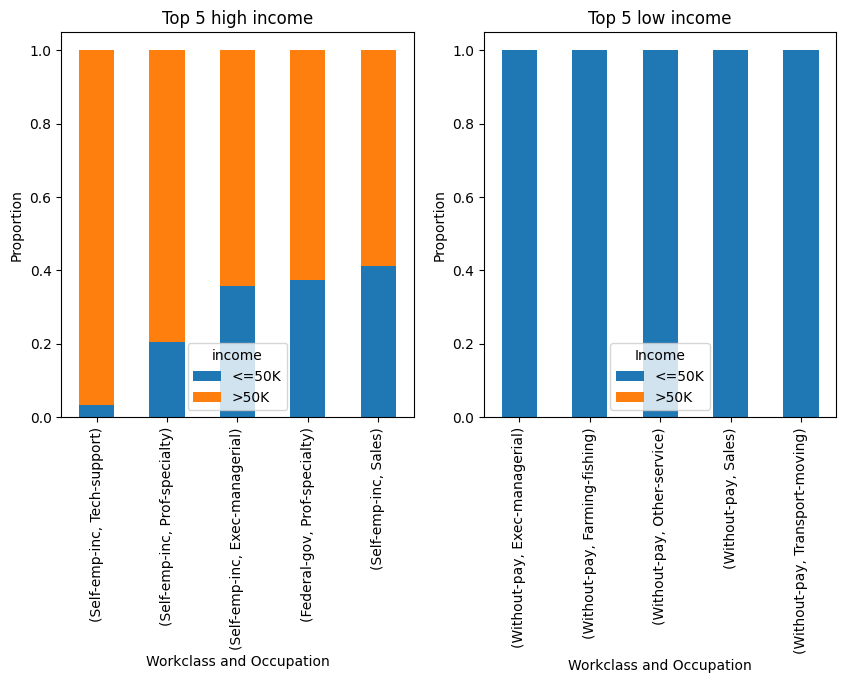

In [70]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))

proportions_top = proportions.head()
proportions_top.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Top 5 high income')
axes[0].set_xlabel('Workclass and Occupation')
axes[0].set_ylabel('Proportion')

proportions_bottom = proportions.tail()
proportions_bottom.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Top 5 low income')
axes[1].set_xlabel('Workclass and Occupation')
axes[1].set_ylabel('Proportion')
plt.legend(title='Income')
plt.show()

### Income distribution by Education

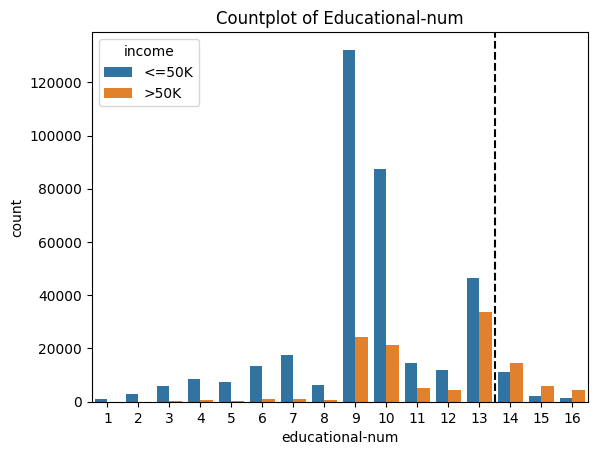

In [71]:
sns.countplot(data=df, x='educational-num', hue='income')
x_labels = sorted(df['educational-num'].unique())
x_pos_13 = x_labels.index(13) + 0.5  # position between 13 and 14

plt.axvline(x=x_pos_13, color='black', linestyle='--')

plt.title('Countplot of Educational-num')
plt.show()

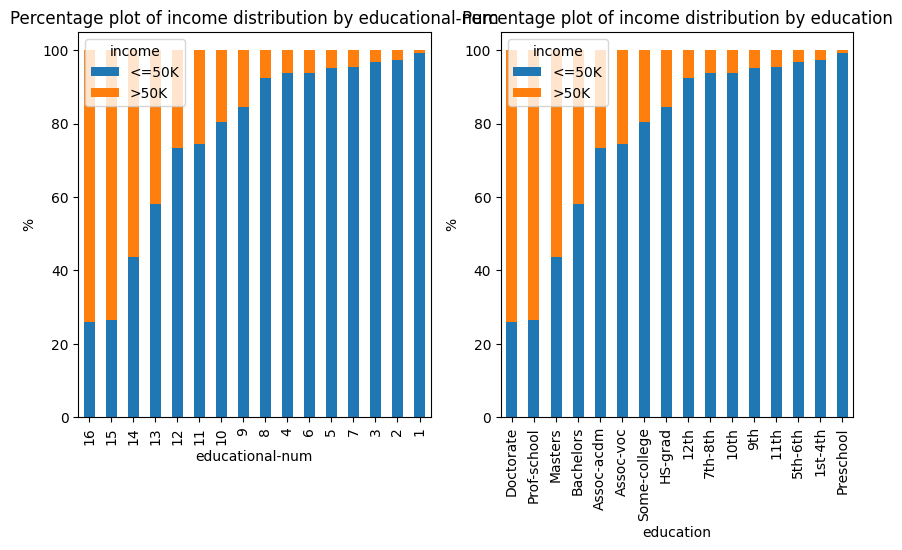

In [72]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
stacked_bar_income('educational-num', axes[0])
stacked_bar_income('education', axes[1])

The distribution of educational-num match education. Education of Bachelors or has higher rate of >50k income, and if master or above, more than half of the people earns >50k.

### Income distribution by Race & Gender

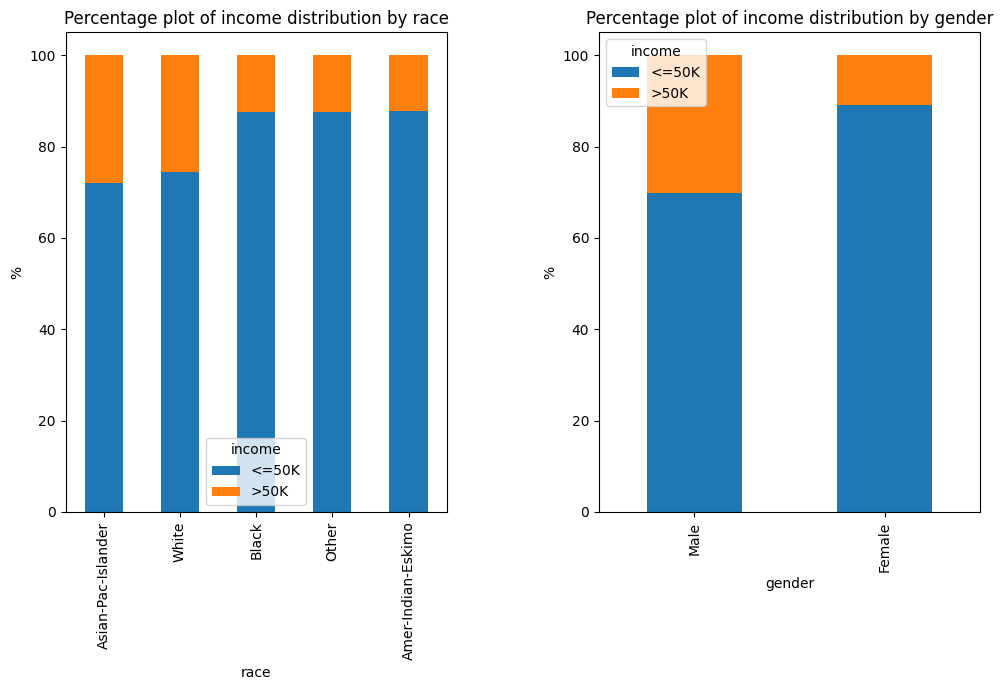

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
stacked_bar_income('race', ax=axes[0])
stacked_bar_income('gender', ax=axes[1])

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)  
plt.show()

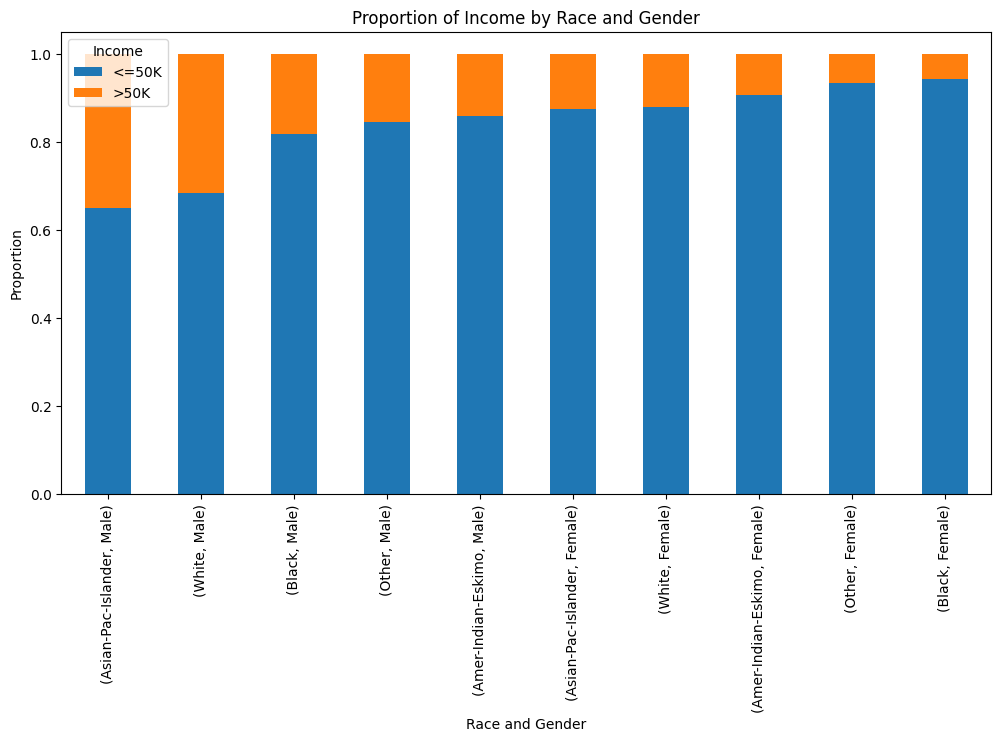

In [74]:
proportions = df.groupby(['race', 'gender'])['income'].value_counts(normalize=True).unstack().sort_values(by='>50K', ascending=False)
proportions.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Proportion of Income by Race and Gender')
plt.xlabel('Race and Gender')
plt.ylabel('Proportion')
plt.legend(title='Income')
plt.show()

### Income distribution by Marital Status

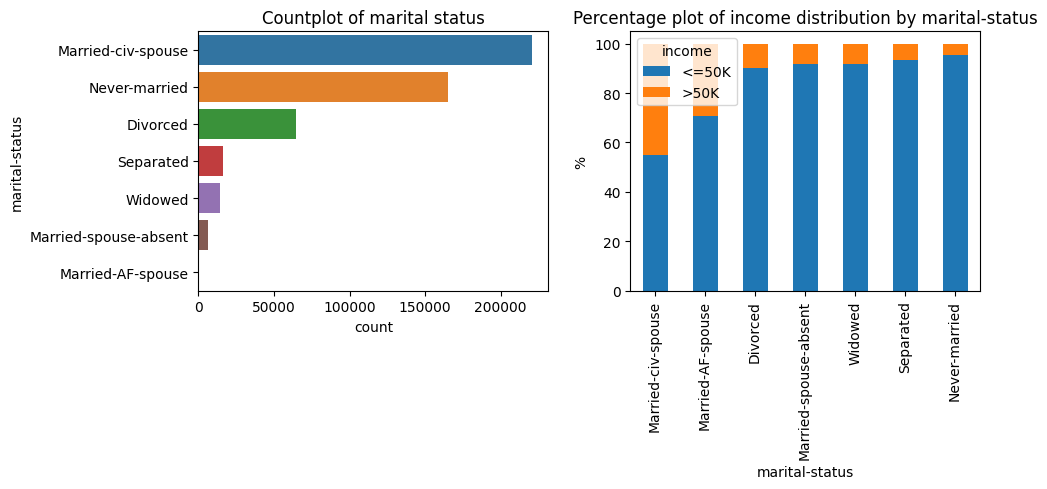

In [75]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
sns.countplot(y='marital-status', data=df, ax=axes[0], order=df['marital-status'].value_counts().index)
axes[0].set_title('Countplot of marital status')
stacked_bar_income('marital-status', axes[1])
plt.subplots_adjust(wspace=5)  
plt.tight_layout()
plt.show()

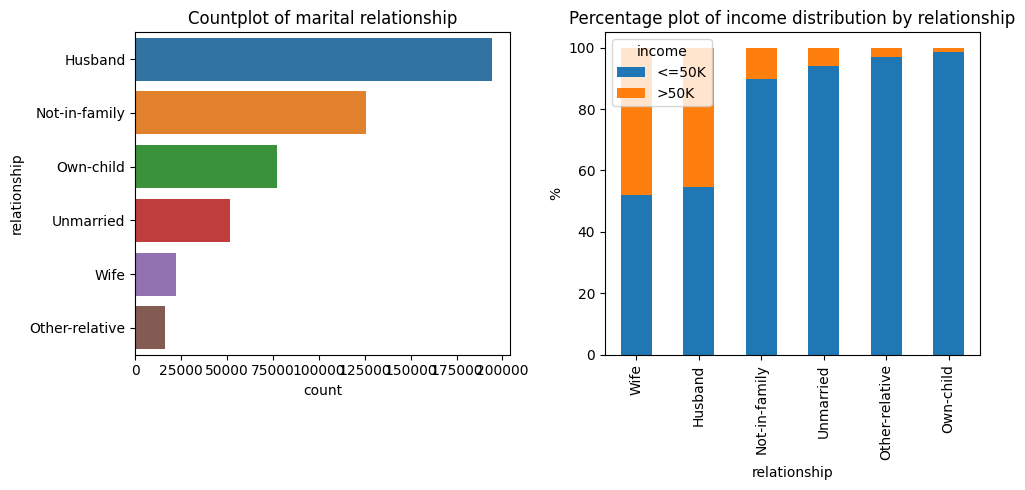

In [76]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
sns.countplot(y='relationship', data=df, ax=axes[0], order = df['relationship'].value_counts().index)
axes[0].set_title('Countplot of marital relationship')
stacked_bar_income('relationship', axes[1])
plt.subplots_adjust(wspace=5)  
plt.tight_layout()
plt.show()

In [77]:
# Create contingency table
contingency_table = pd.crosstab([df['race'], df['gender']], df['income'])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-Square Statistic: {chi2}')
print(f'p-value: {p}')

Chi-Square Statistic: 25388.622034967037
p-value: 0.0


### Correlation Analysis

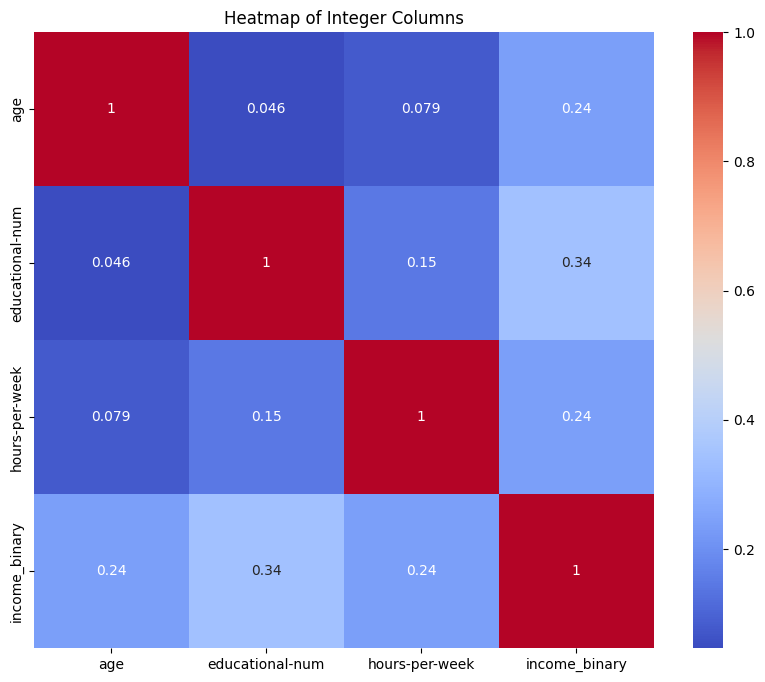

In [78]:
num_columns = df.select_dtypes(include=['int'])
plt.figure(figsize=(10, 8))
sns.heatmap(num_columns.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Integer Columns')
plt.show()

In [79]:
for cols in num_columns.columns.drop('income_binary'):
    print(f"{cols}: {pearsonr(df[cols], df.income_binary)}")

age: PearsonRResult(statistic=0.23899259418096075, pvalue=0.0)
educational-num: PearsonRResult(statistic=0.3421375634324587, pvalue=0.0)
hours-per-week: PearsonRResult(statistic=0.23762543016863627, pvalue=0.0)


##  Data Preprocessing

In [81]:
# Remove column education. We will use educational-num for modeling
# Remove income. We will use income_binary
# Remove capital-gain and capital-loss. Too many 0 values
# Remove native-country because mostly united-states
df = df.drop(columns=['education', 'income', 'native-country'])

In [82]:
df.head()

,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,income_binary
41952,24,Private,10,Never-married,Machine-op-inspct,Own-child,Other,Male,14,0
12610,38,Private,7,Widowed,Craft-repair,Unmarried,White,Male,40,0
5330,23,Private,11,Never-married,Adm-clerical,Not-in-family,White,Male,50,0
17705,53,Federal-gov,9,Married-civ-spouse,Adm-clerical,Husband,Black,Male,40,0
7163,28,Private,9,Divorced,Adm-clerical,Not-in-family,White,Female,40,0


In [83]:
X = df.drop(columns=['income_binary'])
y = df['income_binary']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

ct = make_column_transformer(
    (StandardScaler(), numerical_cols),
    (OneHotEncoder(sparse_output=False, drop='if_binary'), categorical_cols), 
    verbose_feature_names_out=False
)

ct.set_output(transform='pandas')
X_preprocessed = ct.fit_transform(X)
X_preprocessed.head()

,age,educational-num,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Male
41952,-1.040324,-0.012016,-2.165493,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
12610,-0.005645,-1.160559,-0.025634,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5330,-1.114230,0.370831,0.797388,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
17705,1.102939,-0.394864,-0.025634,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7163,-0.744702,-0.394864,-0.025634,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((365865, 46), (121955, 46), (365865,), (121955,))

## Modeling

In [85]:
# List of models to try
model_list1 = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),    
}

# Train and evaluate each model
for model_name, model in model_list1.items():
    # Train the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    # Evaluate the model
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.8401131564921488
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90     92795
           1       0.70      0.58      0.63     29160

    accuracy                           0.84    121955
   macro avg       0.79      0.75      0.77    121955
weighted avg       0.83      0.84      0.83    121955


Model: Decision Tree
Accuracy: 0.962502562420565
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     92795
           1       0.93      0.91      0.92     29160

    accuracy                           0.96    121955
   macro avg       0.95      0.94      0.95    121955
weighted avg       0.96      0.96      0.96    121955


Model: Random Forest
Accuracy: 0.9627485547948014
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     92795
           

In [86]:
model_list2 = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

for model_name, model in model_list2.items():
    # Train the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    # Evaluate the model
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")

Model: K-Nearest Neighbors
Accuracy: 0.9520806854987496
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     92795
           1       0.90      0.90      0.90     29160

    accuracy                           0.95    121955
   macro avg       0.93      0.93      0.93    121955
weighted avg       0.95      0.95      0.95    121955


Model: Naive Bayes
Accuracy: 0.6830962240170555
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.62      0.75     92795
           1       0.42      0.88      0.57     29160

    accuracy                           0.68    121955
   macro avg       0.68      0.75      0.66    121955
weighted avg       0.82      0.68      0.71    121955




We will pick Decision Tree because it performed the best and easy to interpret, especially when our goal is to provide actionable insights for students to make informed life choices.

In [93]:
param_grid = {
    'max_depth': [None, 2, 3, 5, 10, 20, 30, 40, 50],
}

# Initialize the Decision Tree model
dt = DecisionTreeClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best estimator
best_dt = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")

# Print classification report
print(classification_report(y_test, y_pred))

Best parameters: {'max_depth': None}
Test set accuracy: 0.962502562420565
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     92795
           1       0.93      0.91      0.92     29160

    accuracy                           0.96    121955
   macro avg       0.95      0.94      0.95    121955
weighted avg       0.96      0.96      0.96    121955



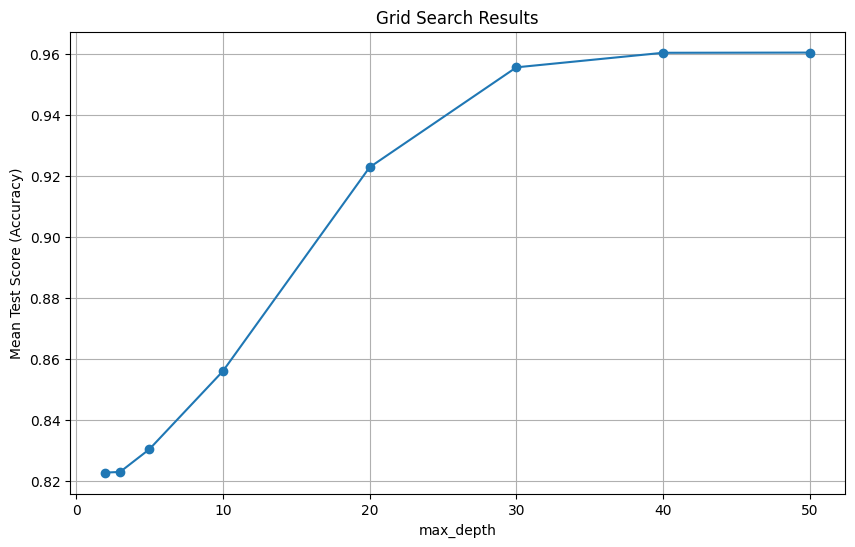

In [94]:
results = pd.DataFrame(grid_search.cv_results_)

# Plot the mean test score against max_depth
plt.figure(figsize=(10, 6))
plt.plot(param_grid['max_depth'], results['mean_test_score'], marker='o')
plt.xlabel('max_depth')
plt.ylabel('Mean Test Score (Accuracy)')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()